# Анализ удовлетворенности клиентов. Исследование комфорта при работе климатического оборудования.

## Описание проекта

### Поставленная задача

Проанализировать полученные данные и предоставить выводы о том, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворенность клиентов созданными условиями в зависимости от региона? И на что стоит обратить внимание при развитии бизнеса в разных регионах?

### Описание данных

**Год** - Год проведения исследования<br>
**Время года** - Весна, лето, осень, зима<br>
**Климат** - Название типа климата<br> 
**Город** - Город, где было проведено исследование<br> 
**Страна** - Страна, где было проведено исследование<br>
**Способ охлаждения**:<br>
- **Кондиционирование** = может быть разных типов, окна закрыты.
- **Вентиляция** = механические системы вентиляции и естественное охлаждение.
- **Смешанный** = механическое охлаждение, окна могут быть как открыты, так и закрыты.
- **NA** = не применимо, например исследование холодной зимой, когда включено отопление.
  
**Режим при смешанном типе охлаждения**:<br>
- **NA** = здания, не относящиеся к смешанному типу.
- **Кондиционер** = кондиционер включен, окна закрыты.
- **Вентиляция** = кондиционер выключен, окна открыты/механическая
	вентиляция.

**Способ обогрева**:
- **Механическое отопление** = в здании имеется механическая система отопления (переносные обогреватели не считаются механическим отоплением на уровне здания).
- **NA** = отсутствие механического отопления, неизвестно или исследование только в жаркую летнюю погоду.
  
**Возраст** - Возраст респондента<br>
**Пол** - Пол респондента<br> 
**Ощущение температуры** - Оценка температуры по ощущениям: от -3 (холодно) до +3 (горячо)<br>
**Ощущение температуры (bool)** - 0 = неприемлемо, 1 = приемлемо<br> 
**Предпочтительное изменение температуры** - Без изменений, теплее, холоднее<br> 
**Ощущение движения воздуха (bool)** - 0 = неприемлемо, 1 = приемлемо <br>
**Предпочтительное изменение движения воздуха** - Меньше, без изменений, больше<br> 
**Оценка комфорта** - От 1 (очень неудобно) до 6 (очень комфортно) <br>
**Утепление** - Фактор связанный с одеждой респондента<br> 
**Температура воздуха в помещении** - Измеренная температура в помещении<br> 
**Температура воздуха на улице** - Измеренная температура на улице <br>
**RH** - Относительная влажность <br>
**Скорость воздуха** - Скорость воздуха, м/с<br> 
**Рост** - Рост респондента<br>
**Вес** - Вес респондента <br>
**Занавески** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Вентилятор** - Режим вентилятора: 0 = выключен, 1 = включен; если неизвестно - нет данных<br> 
**Окно** - 0 = открыто, 1 = закрыто; если неизвестно - нет данных <br>
**Двери** - 0 = открыты, 1 = закрыты; если неизвестно - нет данных<br>
**Отопление** - Режим обогрева: 0 -выключен, 1 - включен; если неизвестно - нет данных<br> 
**Среднемесячная температура на улице** - Среднемесячная температура наружного воздуха на момент исследования, C.<br>
**Количество рекламаций** - Количество жалоб на установленное оборудование, полученных от клиента, за прошедший период<br>

## Imports

### Скачивание библиотек

In [ ]:
pip install pandas

In [ ]:
pip install numpy

In [ ]:
pip install matplotlib

In [ ]:
pip install scipy

In [ ]:
pip install seaborn

In [ ]:
pip install -U scikit-learn

In [ ]:
pip install statsmodels

### Подключение библиотек

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr, mannwhitneyu, ttest_ind, shapiro, kruskal, f_oneway
from statsmodels.stats.multitest import multipletests

## Path

In [121]:
MAIN_TABLE = 'data.csv'

## User functions

In [122]:
class SeparatorError(Exception):
    """Пользовательское исключение для ошибки разделителя в CSV файле."""
    pass


def read_file(PATH):
    """
    Чтение файла CSV с автоматическим определением параметров и форматированием названий столбцов.

    Функция пытается прочитать CSV-файл, автоматически определяя кодировку и разделитель.
    Приводит названия столбцов к формату PEP8 (нижний регистр, подчеркивание вместо пробелов).

    Аргументы:
        PATH (str): Путь к файлу для чтения.

    Возращает:
        pd.DataFrame: 
            - Успешное чтение: DataFrame с данными
            - Ошибка: DataFrame с одной колонкой 'error', содержащей тип ошибки:
                * 'encoding' - проблемы с кодировкой
                * 'separator' - проблемы с разделителем
                * 'file_path' - файл не найден
    """
    encodes = ['utf-8', 'cp1251']
    separators = [';', ',']
    dcml = '.'
    data = pd.DataFrame()
    for encode in encodes:
        for separator in separators:
            try:
                data = pd.read_csv(PATH, sep=separator, encoding=encode, decimal=dcml)
                data.columns = data.columns.str.lower().str.replace(' ', '_')
                if len(data.columns) == 1:
                    raise SeparatorError
                return data
            except UnicodeError:
                data = pd.DataFrame({'error': ['encoding']})
            except SeparatorError:
                data = pd.DataFrame({'error': ['separator']})
            except FileNotFoundError:
                data = pd.DataFrame({'error': ['file_path']})
    return data

In [123]:
def change_types(data, columns):
    """
    Изменяет типы данных указанных столбцов в DataFrame с обработкой ошибок.

    Функция последовательно преобразует типы данных столбцов согласно переданному
    словарю соответствий. Предусмотрена обработка ошибок преобразования типов.

    Аргументы:
        data (pd.DataFrame): Исходный DataFrame для преобразования
        columns (dict): Словарь преобразований формата:
            {
                'название_столбца': тип_данных,
                ...
            }
            Поддерживаемые типы: int, float, str, 'category', bool, datetime64 и др.

    Возращает:
        None: Изменения применяются непосредственно к переданному DataFrame (inplace)
    """
    for key, val in columns.items():
        try:
            data[key] = data[key].astype(val)
        except ValueError:
            print('Ошибка при изменении типа данных в столбце с именем ', key)
        except KeyError:
            print('Возможно было неправильно указано название столбца', key)

In [124]:
def unique_values(data, columns):
    """
    Выводит уникальные значения для указанных столбцов DataFrame в читаемом формате.

    Функция анализирует и отображает все уникальные значения для каждого указанного столбца,
    разделяя результаты визуальными маркерами для удобства чтения.

    Args:
        data (pd.DataFrame): Исходный DataFrame для анализа
        columns (list): Список названий столбцов, для которых нужно показать уникальные значения

    Returns:
        None: Результаты выводятся в консоль
    """
    print('###########')
    print(*['\n###########\n'.join([column, '\n'.join(data[column].unique())]) for column in columns], sep='\n\n###########\n')

In [125]:
def correlation_ratio(categories, values):
    """
    Вычисляет корреляционное отношение (η) между категориальной и количественной переменными.

    Корреляционное отношение (Eta coefficient) измеряет степень связи между номинальной
    и интервальной переменными. Значение варьируется от 0 (отсутствие связи) до 1 (полная зависимость).

    Аргументы:
        categories (array-like или pd.Series): Категориальная переменная (группирующая)
        values (array-like или pd.Series): Количественная переменная (непрерывная)

    Возвращает:
        float: Значение корреляционного отношения η в диапазоне [0, 1] или np.nan,
              если вычисление невозможно
    """
    categories = np.array(categories)
    values = np.array(values)    
    ssw = 0
    ssb = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        ssw += sum((subgroup - np.mean(subgroup)) ** 2)
        ssb += len(subgroup) * (np.mean(subgroup) - np.mean(values)) ** 2
    if ssb + ssw == 0:
        return np.nan
    return (ssb / (ssb + ssw)) ** 0.5

In [126]:
def my_cramers(x, y):
    """
    Вычисляет коэффициент корреляции Крамера между двумя категориальными переменными.

    Коэффициент Крамера (V) измеряет силу связи между двумя номинальными переменными.
    Значение варьируется от 0 (нет связи) до 1 (полная зависимость). Используется
    как мера ассоциации для таблиц сопряженности любого размера.

    Аргументы:
        x (pd.Series или array-like): Первая категориальная переменная
        y (pd.Series или array-like): Вторая категориальная переменная

    Возвращает:
        float: Значение коэффициента Крамера V в диапазоне [0, 1]
    """
    data = pd.crosstab(x, y)
    n = data.sum().sum()
    theory = np.outer(data.values.sum(axis=1),
                      data.values.sum(axis=0)) / n
    chi2 = ((data.values - theory) ** 2 / theory).sum()
    chi2 = chi2_contingency(data)[0]
    r, c = data.values.shape
    if min(r - 1, c - 1) == 0:
        cramer = 0
    else:
        cramer = np.sqrt(chi2 / (n * min(r - 1, c - 1)))
    return cramer

In [127]:
# columns - список названий столбцов, по которым будем строить ящик с усами.

def boxplot_chart(data, columns):
    """
    Строит диаграммы "ящик с усами" (boxplot) для указанных числовых столбцов.

    Функция создает отдельные boxplot-диаграммы для каждого указанного столбца,
    что позволяет визуально оценить распределение данных, выявить выбросы и сравнить
    основные статистические характеристики.

    Аргументы:
        data (pd.DataFrame): Исходный датафрейм с данными для визуализации
        columns (list): Список названий числовых столбцов для анализа

    Возвращает:
        None: Функция выводит графики через matplotlib.pyplot.show()
    """
    for column in columns:
        sns.boxplot(data, y=column)
        plt.title(f'График ящик с усами для столбца {column}', loc='center')
        plt.show()       

In [128]:
def addnew_col_for_pie(data, new_col, col, val0, val1, valnan):
    """
    Создает новый категориальный столбец на основе булевых значений с возможностью кастомизации.

    Функция преобразует булевы/бинарные значения в произвольные категориальные метки,
    что особенно полезно для подготовки данных к визуализации (например, для круговых диаграмм).

    Аргументы:
        data (pd.DataFrame): Исходный датафрейм для преобразования
        new_col (str): Название создаваемого столбца
        col (str): Название исходного столбца с бинарными данными (0/1)
        val0 (any): Значение для замены 0 (False)
        val1 (any): Значение для замены 1 (True)
        valnan (any): Значение для замены NaN (пропущенных значений)

    Возвращает:
        None: Исходный датафрейм с добавленным новым столбцом (изменения происходят inplace)
    """
    data[new_col] = data[col].replace({0: val0, 1: val1, np.nan: valnan})

In [129]:
# напишем функцию первичной проверки данных
def check_data(data):
    """
    Проводит комплексный первичный анализ данных с визуализацией.

    Функция выполняет:
    - Анализ структуры данных
    - Проверку на пропущенные значения
    - Поиск дубликатов
    - Описательную статистику
    - Визуализацию распределений

    Аргументы:
        data (pd.DataFrame): Анализируемый датафрейм. Может содержать как количественные,
                            так и категориальные переменные.

    Возвращает:
        None: Функция выводит результаты анализа в виде:
            - Текстовых сводок
            - Таблиц
            - Графиков
    """
    print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
    print(data.info())
    # проверим nan
    print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
    print('Количество пропусков:\n{:.0f}'.format(data.isnull().sum().sum()))
    print('Доля пропусков:\n{}'.format(data.isna().mean()))
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isna().T)
    plt.suptitle('Оценка пропусков на heatmap')
    plt.show()
    print()
    # проверим дубликаты
    print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
    print('Количество полных дубликатов:\n', data.duplicated().sum())
    # посмотрим на сами данные
    print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
    display(data.head(10))
    print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
    display(data.describe(exclude=['object']).T)
    print('\033[1m' + '\nГрафическое представление количественных данных:' + '\033[0m')
    for numeric_column in data.select_dtypes(exclude=['object', 'category']).columns:
        sns.histplot(data[numeric_column])
        plt.suptitle(f'Гистограмма распределения ({numeric_column})')
        plt.show()
        print()
    print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
    display(data.describe(include=['object']).T)
    print('\033[1m' + '\nГрафическое представление категориальных данных:' + '\033[0m')
    for category in data.select_dtypes(include=['object']).columns:
        table = data[category].value_counts()
        plt.pie(table, labels=table.index, autopct='%1.1f%%')
        title = category.rstrip('_кат')
        plt.suptitle(f'Круговая диаграмма распределения {title}')
        plt.show()

In [130]:
def conclusion(stat, p, method):
    """
    Формирует интерпретацию результатов статистического теста для отчета.

    Функция анализирует результаты статистического теста и формирует понятный вывод
    о наличии/отсутствии статистически значимых различий между группами с визуальными
    индикаторами результата.

    Аргументы:
        stat (float): Значение статистики теста (t-критерий, U-критерий и т.д.)
        p (float): Полученное p-значение (уровень значимости)
        method (str): Название использованного статистического метода

    Возвращает:
        str: Готовый вывод с интерпретацией результатов в формате:
            "Метод: [название метода], stat: [значение], p-value: [значение], [вывод]"
    """
    if p < 0.05:
        return f"Метод: {method}, stat: {stat}, p-value: {p}, ✅ Различия в оценке комфорта между группами статистически значимы."
    else:
        return f"Метод: {method}, stat: {stat}, p-value: {p}, 🚫 Различий в комфорте между группами не выявлено."

In [131]:
def pairwise_comparison_mannwhitn(groupby, col):
    """
    Выполняет попарное сравнение групп с помощью U-критерия Манна-Уитни.

    Функция проводит попарное сравнение независимых выборок для категориально-количественных
    данных с ненормальным распределением. Используется для сравнения медиан между группами.

    Аргументы:
        groupby (str): Название категориального столбца, по которому производится группировка.
                      Определяет группы для сравнения.
        col (str): Название количественного столбца с измеряемыми значениями для сравнения.

    Возвращает:
        tuple: Кортеж, содержащий:
            - pvals (list): Список p-значений для каждой пары сравнений
            - comparisons (list): Список строк с описанием сравниваемых пар групп
              в формате "группа1 vs группа2"
    """
    df2 = df[[groupby, col]].dropna()
    groups = df2.groupby(groupby)[col].apply(list)
    group_names = groups.index.tolist()
    group_data = [groups[name] for name in group_names]

    pvals = []
    comparisons = []
    
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            u_stat, p = mannwhitneyu(group_data[i], group_data[j], alternative='two-sided')
            pvals.append(p)
            comparisons.append(f"{group_names[i]} vs {group_names[j]}")
    return pvals, comparisons

In [132]:
def testing_statistical_hypotheses(df, columns, values=None):
    '''
    Функция автоматически выбирает подходящий статистический тест на основе:
    - Количества групп (2 или более)
    - Нормальности распределения (тест Шапиро-Уилка)
    
    Для двух групп выбирает между t-тестом Стьюдента или тестом Манна-Уитни.
    Для нескольких групп выбирает между ANOVA или тестом Краскела-Уоллиса.

    Аргументы:
        df (pandas.DataFrame): Входной DataFrame с данными для анализа.
        columns (list): Список названий столбцов, где:
            - Первый элемент - категориальная переменная для группировки
            - Второй элемент - количественная переменная для сравнения
        values (list, optional): Для бинарных сравнений указывает, какие два значения
            группирующей переменной сравнивать. По умолчанию None.

    Возвращает:
        tuple: Кортеж содержащий:
            - stat (float): Рассчитанная статистика теста
            - p (float): p-значение теста
            - method (str): Название использованного статистического теста
    '''
    
    levels = df[columns[0]].dropna().unique()
    if len(levels) > 2:
        groups = [group['оценка_комфорта'].dropna().values for name, group in df.groupby('способ_охлаждения')]
        
        if len(set([shapiro(i) for i in groups])) == 1:
            method = 'ANOVA'
            stat, p = f_oneway(*groups)
        else:
            method = 'Краскела–Уоллиса'
            stat, p = kruskal(*groups)
        return stat, p, method
    else:
        df2 = df[[*columns]].dropna()

        sample_1 = df2[df2[columns[0]] == values[0]][columns[1]]
        sample_2 = df2[df2[columns[0]] == values[1]][columns[1]]

        if shapiro(sample_1)[1] >= 0.05 and shapiro(sample_2)[1] >= 0.05:
            method = 'Стьюдент'
            stat, p = ttest_ind(sample_1, sample_2, equal_var=False)
        else:
            method = 'Манн-Уитни'
            stat, p = mannwhitneyu(sample_1, sample_2, alternative='two-sided')
            
        return stat, p, method
        
    return np.nan, np.nan

In [133]:
def analize(df, cnt):
    """
    Проводит анализ оценки комфорта по категориям влажности для указанной страны.

    Функция выполняет:
    1. Фильтрацию данных по указанной стране
    2. Проверку нормальности распределения оценок комфорта для каждой категории влажности
    3. Непараметрический статистический тест (Краскела-Уоллиса) для сравнения групп

    Аргументы:
        df (pd.DataFrame): Исходный DataFrame с колонками:
            - 'страна': категориальная переменная с названиями стран
            - 'категория_влажности': категориальная переменная с группами влажности
            - 'оценка_комфорта': количественная переменная с оценками комфорта
        cnt (str): Название страны для анализа

    Возращает:
        None: Результаты выводятся в консоль
    """
    print('Страна:', cnt)
    dt = df[df['страна'] == cnt]
    gr = []
    # Группируем по категориям влажности
    for cat in dt['категория_влажности'].unique():
        gr.append([cat, dt[dt['категория_влажности'] == cat]['оценка_комфорта'].dropna()])
    # Проверка на нормальность
    for nm, v in gr:
        _, pv = shapiro(v)
        print(nm, '- Shapiro', 'p =', round(pv, 4))
    # Данные не распределнны нормально так что используем Краскела Уолеса
    _, p = kruskal(*[i[1] for i in gr])
    print('Краскела Уолеса p =', round(p, 4))

In [134]:
def kolvo_complaints_cat(kolvo):
    """
    Классифицирует количество жалоб на категории 'мало', 'средне', 'много'.

    Функция принимает количество жалоб и возвращает соответствующую текстовую категорию
    согласно заданным критериям классификации.

    Аргументы:
        kolvo (int): Количество жалоб для классификации. Должно быть целым неотрицательным числом.

    Возращает:
        str: Категория количества жалоб:
            - 'мало' - если 0 или 1 жалоба
            - 'средне' - если 2 жалобы
            - 'много' - если 3 и более жалоб
    """
    if kolvo <= 1:
        return 'мало'
    elif kolvo == 2:
        return 'средне'
    return 'много'

In [135]:
def age_category(age):
    """
    Классифицирует возраст человека по категориям: молодой, средний, пожилой.

    Функция принимает возраст в годах и возвращает соответствующую возрастную категорию
    согласно стандартной медицинской классификации.

    Args:
        age (int): Возраст в годах. Должен быть положительным числом.

    Returns:
        str: Возрастная категория:
            - 'молодой возраст' - от 0 до 44 лет включительно
            - 'средний возраст' - от 45 до 59 лет включительно
            - 'пожилой возраст' - 60 лет и старше
    """
    if age <= 44:
        return 'молодой возраст'
    elif 45 <= age <= 59:
        return 'средний возраст' 
    return 'пожилой возраст'

In [136]:
""" Согласно международным рекомендациям:
ASHRAE (Американское общество инженеров по отоплению, охлаждению и кондиционированию воздуха):
Рекомендуемая относительная влажность в помещениях (включая офисы) — от 30% до 60%.
Комфортный диапазон — 40–60%. """

def cat_hum(rh):
    """
    Классифицирует уровень относительной влажности воздуха согласно стандартам ASHRAE.

    Функция определяет категорию влажности на основе рекомендаций Американского общества
    инженеров по отоплению, охлаждению и кондиционированию воздуха (ASHRAE).

    Aргументы:
        rh (float): Значение относительной влажности в процентах (0-100%).

    Возращает:
        str: Категория влажности:
            - 'низкая_влажность' - менее 30%
            - 'комфортная_влажность' - от 30% до 60% (оптимальный диапазон)
            - 'высокая_влажность' - более 60%
    """
    if rh < 30:
        return 'низкая_влажность'
    elif 30 <= rh <= 60:
        return 'комфортная_влажность'
    return 'высокая_влажность'

Ссылка на статью про относительную влажность: https://www.iksmedia.ru/articles/5883239-Novye-rekomendacii-ASHRAE-vyzov-ene.html

In [137]:
# Категоризация категориальных факторов методом OneHotEncoder.
# ohe = OneHotEncoder(sparse_output=False, drop='first')


# def get_ohe(train, categ):
#     temp_df = pd.DataFrame(data=ohe.transform(train[categ]), columns=ohe.get_feature_names_out())
#     data = pd.concat([train.reset_index(drop=True), temp_df], axis=1)
#     data = data.drop(columns=categ, axis=1)
#     return data

## EDA

Чтение данных из файла и приведение названия столбцов в соответствии с PEP8.

In [138]:
df = read_file(MAIN_TABLE)
df.sample(10)

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,скорость_воздуха,рост,вес,занавески,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций
405,2012.0,Зима,Влажный субтропический муссонный,Дели,Индия,Смешанный,Вентиляция,NaN,45.0,Женский,...,0.09,152.4,70.0,NaN,0.0,NaN,NaN,NaN,15.5,0
269,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,25.0,Женский,...,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0
212,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,45.0,Мужской,...,0.07,NaN,NaN,NaN,NaN,NaN,1.0,NaN,22.0,0
95,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,35.0,Мужской,...,0.12,NaN,NaN,NaN,NaN,0.0,1.0,NaN,22.0,0
334,2012.0,Весна,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,NaN,Мужской,...,0.01,NaN,65.0,NaN,NaN,0.0,0.0,NaN,30.4,0
23,2011.0,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,37.0,NaN,...,0.07,NaN,NaN,0.0,0.0,NaN,NaN,NaN,32.8,1
341,2012.0,Лето,Жаркий полузасушливый,Ахмедабад,Индия,Смешанный,Кондиционирование,NaN,35.0,Женский,...,0.10,163.0,82.0,NaN,NaN,0.0,NaN,1.0,29.5,1
176,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Кондиционирование,Механическое отопление,45.0,Женский,...,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0
198,2010.0,Лето,Cубтропический океанический,Сидней,Австралия,Смешанный,Вентиляция,Механическое отопление,45.0,Мужской,...,0.08,NaN,NaN,NaN,NaN,1.0,NaN,NaN,22.0,0
394,2012.0,Лето,Жаркий полузасушливый,Ахмедабад,Индия,Смешанный,Кондиционирование,NaN,25.0,Мужской,...,0.21,170.2,58.0,NaN,NaN,NaN,NaN,1.0,29.5,0


Проверим название столбцов

In [139]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_(bool)',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_(bool)',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')

Уберем лишнее

In [140]:
df.columns = df.columns.str.replace('(', '').str.replace(')', '')
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_bool',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций'],
      dtype='object')

Выведем информацию про каждый столбец

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    float64
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

In [142]:
# заменим для удобства все 0 и 1 в занавески, вентилятор, окно, двери, отопление на закрыты и открыты
for col in ['занавески', 'окно', 'двери']:
    addnew_col_for_pie(df, f'{col}_кат', col, 'открыто', 'закрыто', 'не определен')

addnew_col_for_pie(df, 'вентилятор_кат', 'вентилятор', 'выключен', 'включен', 'не определен')

In [143]:
columns = {'год': int, 'возраст': float, 'ощущение_температуры': float, 'ощущение_температуры_bool': bool, 
           'ощущение_движения_воздуха_bool': bool, 'оценка_комфорта': float, 'утепление': float,
           'температура_воздуха_в_помещении': float, 'температура_воздуха_на_улице': float,
           'rh': float, 'скорость_воздуха': float, 'рост': float, 'вес': float, 'среднемесячная_температура_на_улице': float}
change_types(df, columns)
for column in df.select_dtypes(include=['float64']).columns:
    df[column] = round(df[column], 2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 34 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    int64  
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

Пока не заполнили пропуски в возрасте, его преобразовывать в int нельзя. После заполнения нужно про это вспомнить и изменить.

In [144]:
# для удобного круговых диаграмм создадим категориальные столбцы
addnew_col_for_pie(df, 'отопление_кат', 'отопление', 'выключен', 'включен', 'не определен')

Изучим наши данные с помощью функции, которая осуществляет полноценный графический и описательный анализ наших данных

In [ ]:
check_data(df)

## Preproccesing

### Выбросы

Посмотрим ящики с усами для всех интересующих нас количественных столбцов для выявления возможных выбросов.

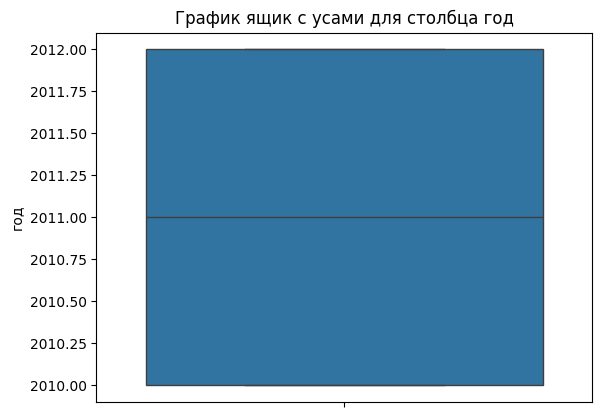

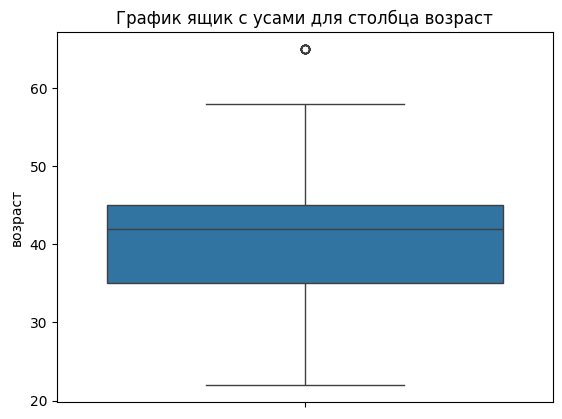

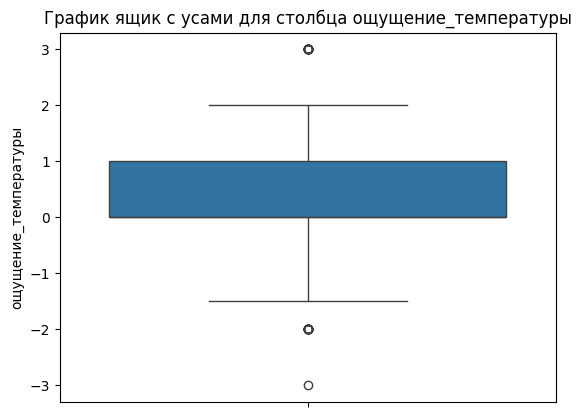

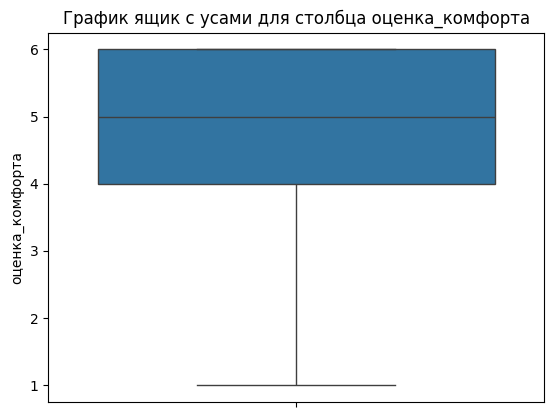

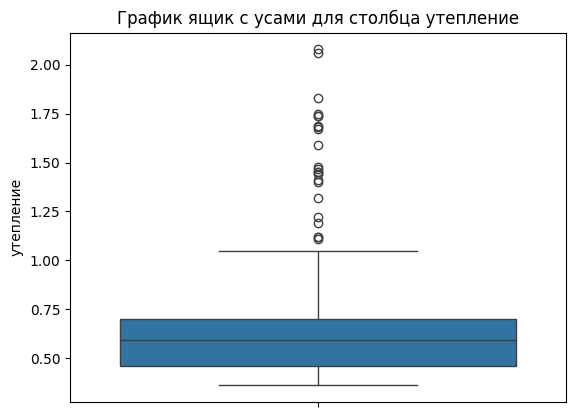

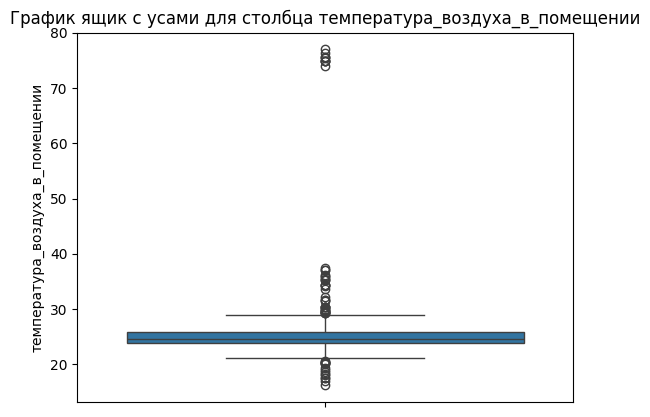

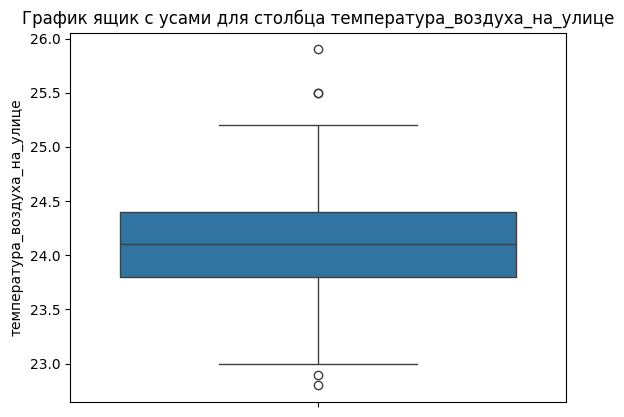

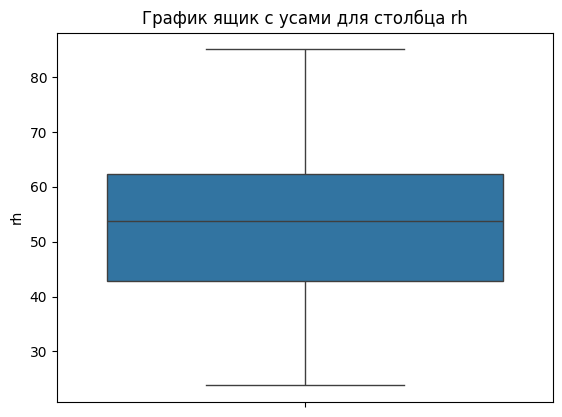

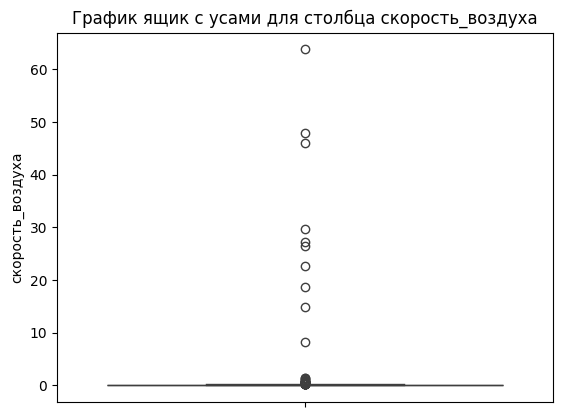

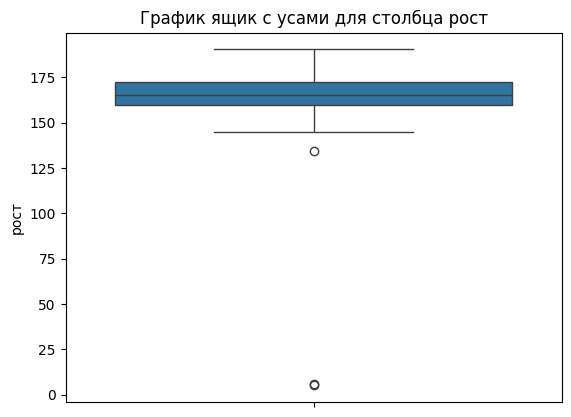

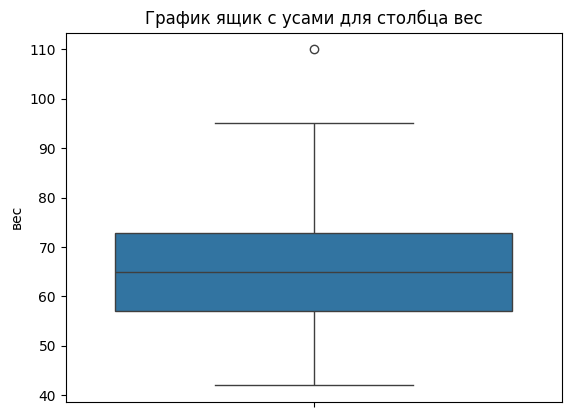

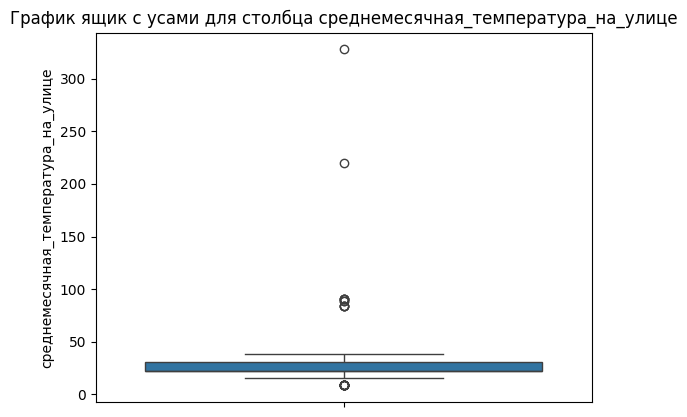

In [146]:
columns = ['год', 'возраст', 'ощущение_температуры', 'оценка_комфорта', 'утепление', 'температура_воздуха_в_помещении',
           'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес', 'среднемесячная_температура_на_улице']
boxplot_chart(df, columns)

In [147]:
df.columns

Index(['год', 'время_года', 'климат', 'город', 'страна', 'способ_охлаждения',
       'режим_при_смешанном_типе_охлаждения', 'способ_обогрева', 'возраст',
       'пол', 'ощущение_температуры', 'ощущение_температуры_bool',
       'предпочтительное_изменение_температуры',
       'ощущение_движения_воздуха_bool',
       'предпочтительное_изменение_движения_воздуха', 'оценка_комфорта',
       'утепление', 'температура_воздуха_в_помещении',
       'температура_воздуха_на_улице', 'rh', 'скорость_воздуха', 'рост', 'вес',
       'занавески', 'вентилятор', 'окно', 'двери', 'отопление',
       'среднемесячная_температура_на_улице', 'количество_рекламаций',
       'занавески_кат', 'окно_кат', 'двери_кат', 'вентилятор_кат',
       'отопление_кат'],
      dtype='object')

Сделаем выводы по этим графикам: <br>
- со столбцом год все нормально.
- со столбцом возраст все нормально.
- к столбцу ощущение_температуры есть вопросы. Взглянем на строки, где встретились выбросы.
- со столбцом оценка_комфорта выбросов не наблюдаем, по значениям будет обговорено позже.
- со стобцом утепление нужно разобраться, разобьем его на группы по временам года и посмотрим график.
- со столбцом температура_воздуха_в_помещении нужно разобраться почему присутствуют выбросы. Скорее всего связано со спецификой работы.
- со столбцом температура_воздуха_на_улице все нормально.
- со столбцом rh на первый взгляд все нормально.
- к столбцу скорость_воздуха есть вопросы. Очень странные выбросы.
- к столбцу рост есть вопросы. Посмотрим почему возникли выбросы и разрешим эту проблему.
- со столбцом вес все нормально.(Не можем утверждать, что присутствуют выбросы)
- со столбцом среднемесячная_температура_на_улице проблемы. Рассмотрим строки с этими значениями более подробно.

In [148]:
df.query('ощущение_температуры < -2 | ощущение_температуры > 2')[['климат', 'время_года', 'страна', 'ощущение_температуры', 
                                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                 'среднемесячная_температура_на_улице']].sort_values(by='ощущение_температуры')

,климат,время_года,страна,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
350,Тропическая влажная саванна,Весна,Индия,-3.0,NaN,26.6,30.4
76,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.7,22.0
203,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.1,22.0
176,Cубтропический океанический,Лето,Австралия,3.0,NaN,22.9,22.0
211,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.5,22.0
222,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.4,22.0
261,Cубтропический океанический,Лето,Австралия,3.0,NaN,25.2,22.0
208,Cубтропический океанический,Лето,Австралия,3.0,NaN,23.9,22.0
264,Cубтропический океанический,Лето,Австралия,3.0,NaN,24.8,22.0
283,Жаркий полузасушливый,Весна,Индия,3.0,NaN,28.7,31.5


In [149]:
df['ощущение_температуры'].describe()

count    484.000000
mean       0.203306
std        1.091976
min       -3.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ощущение_температуры, dtype: float64

Однозначных выводов, как заменить выбросы в столбце ощущение_температуры нет.

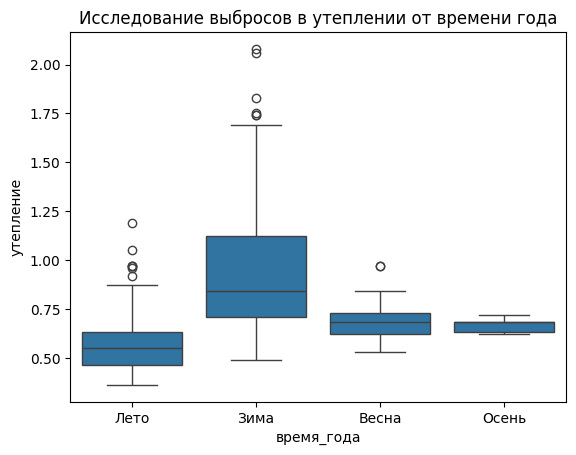

In [150]:
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

Выбросы в утеплении летом могут поломать логику нашего исследования, я хочу устранить их путем заменой на групповую медиану по времени года.

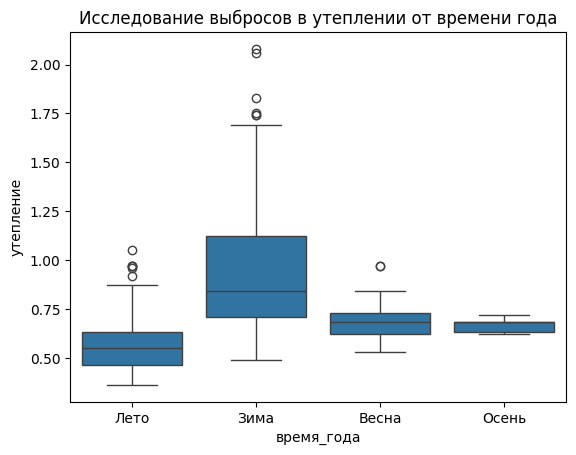

In [151]:
q1 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.25)
q3 = df[df['время_года'] == 'Лето']['утепление'].quantile(0.75)
mask = df[(df['время_года'] == 'Лето') & (df['утепление'] > q3 + 3 * (q3 - q1))].index.to_list()
df.loc[mask, 'утепление'] = df.groupby('время_года')['утепление'].transform('median')
sns.boxplot(data=df, y='утепление', x='время_года')
plt.title('Исследование выбросов в утеплении от времени года')
plt.show()

In [152]:
df.query('температура_воздуха_в_помещении > 40')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                  'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                  'среднемесячная_температура_на_улице']].sort_values(by='температура_воздуха_в_помещении')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
45,Cубтропический океанический,Лето,США,Техас,-1.0,23.3,74.0,31.7
1,Cубтропический океанический,Лето,США,Техас,-2.0,23.7,74.8,84.0
7,Cубтропический океанический,Лето,США,Техас,-2.0,23.6,74.8,32.8
33,Cубтропический океанический,Лето,США,Техас,-1.0,24.2,74.9,32.8
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,74.9,84.0
38,Cубтропический океанический,Лето,США,Техас,1.0,24.3,75.5,28.9
54,Cубтропический океанический,Лето,США,Техас,-2.0,24.1,75.7,28.9
41,Cубтропический океанический,Лето,США,Техас,0.0,24.1,75.7,31.7
9,Cубтропический океанический,Лето,США,Техас,1.0,24.4,76.4,31.7
23,Cубтропический океанический,Лето,США,Техас,1.6,24.7,77.0,32.8


У данных выбросов есть интересная схожесть - страна, где проходили исследования. США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

In [153]:
df['температура_воздуха_в_помещении'] = df['температура_воздуха_в_помещении'].apply(lambda x: x if x < 40 else ((5 / 9) * (x - 32)))
df['температура_воздуха_в_помещении'].describe()

count    484.000000
mean      25.012695
std        2.762848
min       16.200000
25%       23.800000
50%       24.600000
75%       25.700000
max       37.400000
Name: температура_воздуха_в_помещении, dtype: float64

In [154]:
df.query('скорость_воздуха > 1').describe(include=object)

,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,пол,предпочтительное_изменение_температуры,предпочтительное_изменение_движения_воздуха,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
count,13,13,13,13,13,2,1,3,13,13,13,13,13,13,13
unique,2,4,4,2,3,2,1,2,3,3,3,3,2,3,2
top,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Кондиционирование,Механическое отопление,Мужской,Без изменений,Без изменений,закрыто,не определен,не определен,включен,не определен
freq,12,10,10,10,10,1,1,2,9,8,5,10,12,7,12


In [155]:
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe())
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.000000
mean       2.820000
std        9.890699
min        0.030000
25%        0.100000
50%        0.130000
75%        0.210000
max       63.830000
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.000000
mean       0.118309
std        0.140862
min        0.000000
25%        0.060000
50%        0.090000
75%        0.120000
max        1.420000
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.000000
mean      0.204848
std       0.318474
min       0.000000
25%       0.030000
50%       0.060000
75%       0.190000
max       1.430000
Name: скорость_воздуха, dtype: float64




Заполним выбросы медианой по группе относительно способа охлаждения.

In [156]:
q1 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.25)
q3 = df[df['способ_охлаждения'] == 'Кондиционирование']['скорость_воздуха'].quantile(0.75)
mask = df[(df['скорость_воздуха'] > 3 * (q3 - q1) + q3) & (df['способ_охлаждения'] == 'Кондиционирование')].index.to_list()
df.loc[mask, 'скорость_воздуха'] = df.groupby('способ_охлаждения')['скорость_воздуха'].transform('median')
for el in df['способ_охлаждения'].unique():
  print(el, '\nОписательный анализ по столбцу скорость_воздуха')
  print(df[df['способ_охлаждения'] == el]['скорость_воздуха'].describe())
  print('\n')

Кондиционирование 
Описательный анализ по столбцу скорость_воздуха
count    114.000000
mean       0.148333
std        0.082654
min        0.030000
25%        0.100000
50%        0.130000
75%        0.170000
max        0.450000
Name: скорость_воздуха, dtype: float64


Смешанный 
Описательный анализ по столбцу скорость_воздуха
count    337.000000
mean       0.118309
std        0.140862
min        0.000000
25%        0.060000
50%        0.090000
75%        0.120000
max        1.420000
Name: скорость_воздуха, dtype: float64


Вентиляция 
Описательный анализ по столбцу скорость_воздуха
count    33.000000
mean      0.204848
std       0.318474
min       0.000000
25%       0.030000
50%       0.060000
75%       0.190000
max       1.430000
Name: скорость_воздуха, dtype: float64




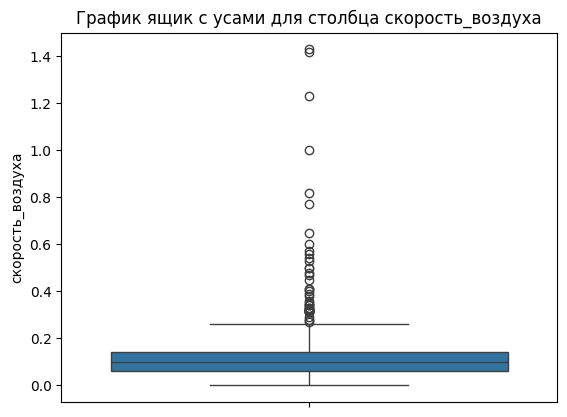

In [157]:
boxplot_chart(df, ['скорость_воздуха'])

In [158]:
df.query(f'рост < {df["рост"].quantile(0.05)}')

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
287,2012,Зима,Влажный субтропический муссонный,Дели,Индия,Смешанный,Вентиляция,NaN,35.0,Мужской,...,0.0,NaN,NaN,15.5,0,не определен,открыто,не определен,выключен,не определен
301,2012,Лето,Субтропическое высокогорье,Шимла,Индия,Смешанный,Вентиляция,Механическое отопление,55.0,Женский,...,NaN,NaN,0.0,18.5,0,не определен,не определен,не определен,не определен,выключен
306,2012,Лето,Субтропическое высокогорье,Шимла,Индия,Вентиляция,NaN,NaN,45.0,Мужской,...,1.0,NaN,NaN,18.5,0,не определен,закрыто,не определен,не определен,не определен
325,2012,Зима,Жаркий полузасушливый,Ахмедабад,Индия,Вентиляция,NaN,NaN,25.0,Женский,...,0.0,NaN,NaN,21.3,0,не определен,открыто,не определен,выключен,не определен
340,2012,Зима,Субтропическое высокогорье,Шимла,Индия,Смешанный,Кондиционирование,Механическое отопление,25.0,Женский,...,0.0,NaN,NaN,8.5,0,не определен,открыто,не определен,не определен,не определен


Можем предпложить, что в Индии длина измеряется по-своему. Возможно это футы или Ilahi Gaz. Но если переводить в эти величины, то можно ужаснутся большими значениями. По тому данные значения будем считать NaN,
в заполнении пропусков будем думать, как такие значения заполнять.

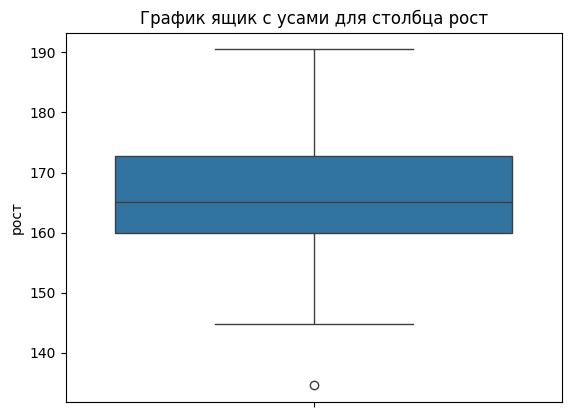

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
340,2012,Зима,Субтропическое высокогорье,Шимла,Индия,Смешанный,Кондиционирование,Механическое отопление,25.0,Женский,...,0.0,NaN,NaN,8.5,0,не определен,открыто,не определен,не определен,не определен


In [159]:
df['рост'] = df['рост'].apply(lambda x: np.nan if x < 10 else x)
boxplot_chart(df, ['рост'])
df.query('рост < 140')

У нас остался один предполагаемый выброс. Мы не можем его таким считать, так как это возможно особенность человека.

In [160]:
df.query(f'среднемесячная_температура_на_улице > {df["среднемесячная_температура_на_улице"].quantile(0.95)}')[['климат', 'время_года', 'страна', 'город', 'ощущение_температуры', 
                                                                                                               'температура_воздуха_на_улице', 'температура_воздуха_в_помещении',
                                                                                                               'среднемесячная_температура_на_улице']].sort_values(by='среднемесячная_температура_на_улице')

,климат,время_года,страна,город,ощущение_температуры,температура_воздуха_на_улице,температура_воздуха_в_помещении,среднемесячная_температура_на_улице
1,Cубтропический океанический,Лето,США,Техас,-2.0,23.7,23.777778,84.0
14,Cубтропический океанический,Лето,США,Техас,-1.5,23.0,23.200000,84.0
67,Cубтропический океанический,Лето,США,Техас,-0.5,23.8,23.833333,84.0
44,Cубтропический океанический,Лето,США,Техас,-2.0,23.9,24.000000,84.0
34,Cубтропический океанический,Лето,США,Техас,2.0,24.1,24.300000,89.0
39,Cубтропический океанический,Лето,США,Техас,2.0,24.4,24.400000,89.0
30,Cубтропический океанический,Лето,США,Техас,-1.3,24.2,24.300000,91.0
20,Cубтропический океанический,Лето,США,Техас,0.0,23.6,23.600000,91.0
68,Cубтропический океанический,Лето,США,Техас,1.5,25.9,26.000000,91.0
28,Cубтропический океанический,Лето,США,Техас,-0.5,24.6,23.900000,91.0


США - там температура измеряется в Фаренгейтах. Воспользуемся формулой перевода в Цельсии для таких выбросов.

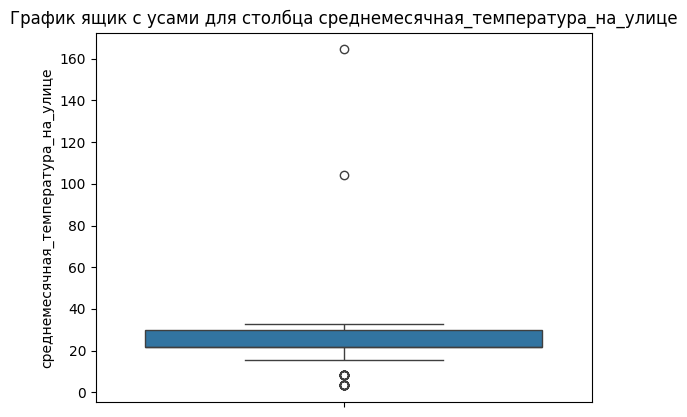

In [161]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < df["среднемесячная_температура_на_улице"].quantile(0.95) else ((5 / 9) * (x - 32)))
df['среднемесячная_температура_на_улице'].describe()
boxplot_chart(df, ['среднемесячная_температура_на_улице'])

Оставшиеся выбросы заменим на NaN для последующей замены на этапе заполнения пропусков

In [162]:
df['среднемесячная_температура_на_улице'] = df['среднемесячная_температура_на_улице'].apply(lambda x: x if x < 100 else np.nan)
df['среднемесячная_температура_на_улице'].describe()

count    482.000000
mean      24.035731
std        6.630709
min        3.388889
25%       22.000000
50%       22.000000
75%       29.900000
max       32.800000
Name: среднемесячная_температура_на_улице, dtype: float64

### Дубликаты

Выявим и заменим неявные дубликаты

In [163]:
duplicates = df[df.duplicated()]
duplicates

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,занавески_кат,окно_кат,двери_кат,вентилятор_кат,отопление_кат
482,2012,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,...,0.0,0.0,NaN,21.6,0,не определен,открыто,открыто,не определен,не определен
483,2012,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Кондиционирование,NaN,NaN,Женский,...,0.0,0.0,NaN,21.6,0,не определен,открыто,открыто,не определен,не определен


In [164]:
df = df.drop_duplicates()

In [165]:
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, df[i].unique())

время_года ['Лето' 'Зима' 'Весна' 'Осень']
климат ['Cубтропический океанический' 'Cубтроп океанич'
 'Субтропическое высокогорье' 'Жаркий полузасушливый'
 'Тропическая влажная саванна' 'Влажный субтропический муссонный']
город ['Техас' 'Сидней' 'Шимла' 'Хайдарабад' 'Бангалор' 'Ахмедабад' 'Ченнай'
 'Дели']
страна ['США' 'Австралия' 'Индия']
способ_охлаждения ['Кондиционирование' 'Смешанный' 'Вентиляция']
режим_при_смешанном_типе_охлаждения [nan 'Кондиционирование' 'Вентиляция']
способ_обогрева [nan 'Механическое отопление']
пол [nan 'Женский' 'Мужской']
предпочтительное_изменение_температуры ['Без изменений' 'Теплее' 'Холоднее' 'Холодн' 'Тепле']
предпочтительное_изменение_движения_воздуха ['Без изменений' 'Меньше' 'Больше']
занавески_кат ['закрыто' 'открыто' 'не определен']
окно_кат ['не определен' 'закрыто' 'открыто']
двери_кат ['не определен' 'открыто' 'закрыто']
вентилятор_кат ['включен' 'выключен' 'не определен']
отопление_кат ['не определен' 'включен' 'выключен']


Заменим опечатки на правильные значения

In [166]:
df['климат'] = df['климат'].map({'Cубтроп океанич': 'Субтропический океанический',
                                 'Cубтропический океанический': 'Субтропический океанический'
                                }).fillna(df['климат'])

In [167]:
df['климат'].unique()

array(['Субтропический океанический', 'Субтропическое высокогорье',
       'Жаркий полузасушливый', 'Тропическая влажная саванна',
       'Влажный субтропический муссонный'], dtype=object)

In [168]:
df['предпочтительное_изменение_температуры'] = df['предпочтительное_изменение_температуры'].map({'Холодн': 'Холоднее',
                                                                                                'Тепле': 'Теплее'}).fillna(df['предпочтительное_изменение_температуры'])


In [169]:
df['предпочтительное_изменение_температуры'].unique()

array(['Без изменений', 'Теплее', 'Холоднее'], dtype=object)

### Пропуски

In [170]:
# Заполнение пропусков 
""" Оно требуется в столбцах возраст ( 71 пропуск ), пол ( 72 пропуска ), 
                             рост ( 341 пропуск ) , вес ( 270 пропусков )  оценка_комфорта ( 269 пропусков ),
                             отопление ( 405 пропусков ) """

# В других столбцах где присутствуют пропуски заполнение точно не требуется

# для начали проанализируем данные столбцы по странам
for col in ['возраст', 'пол', 'рост', 'вес', 'оценка_комфорта', 'отопление']:
    print(col)
    print()
    for cntr in df['страна'].unique():
        print(cntr.ljust(8), '\t', 
              'Кол-во не пустых значений:', str(df[(df['страна'] == cntr) & (df[col].notna())].shape[0]).ljust(3), '\t',
              'Кол-во Nan:', df[(df['страна'] == cntr) & (df[col].isna())].shape[0])
    print()

возраст

США      	 Кол-во не пустых значений: 72  	 Кол-во Nan: 0
Австралия 	 Кол-во не пустых значений: 198 	 Кол-во Nan: 0
Индия    	 Кол-во не пустых значений: 143 	 Кол-во Nan: 69

пол

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Австралия 	 Кол-во не пустых значений: 198 	 Кол-во Nan: 0
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

рост

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
Индия    	 Кол-во не пустых значений: 141 	 Кол-во Nan: 71

вес

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan: 72
Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
Индия    	 Кол-во не пустых значений: 212 	 Кол-во Nan: 0

оценка_комфорта

США      	 Кол-во не пустых значений: 72  	 Кол-во Nan: 0
Австралия 	 Кол-во не пустых значений: 0   	 Кол-во Nan: 198
Индия    	 Кол-во не пустых значений: 143 	 Кол-во Nan: 69

отопление

США      	 Кол-во не пустых значений: 0   	 Кол-во Nan:

In [171]:
# разобьем на разные группы для заполнять для каждой страны отдельно
df_au = df[df['страна'] == 'Австралия'].copy()
df_us = df[df['страна'] == 'США'].copy()
df_in = df[df['страна'] == 'Индия'].copy()

target = 'отопление'

In [172]:
# Заметим, что пустые значения только у страны США, в других заполненны, так что просто оставим np.nan

# Возраст — медиана по полу и по странам (можно заметить что все 71 пропуск из страны Индии"""
df_in['возраст'] = df_in.groupby('пол')['возраст'].transform(lambda x: x.fillna(x.median()))

# Рост - заметим что у страны США и Австралия не заполненно, так что оставим как np.nan
# А вот у Индии заполним по полу средним значением
mn_india_hght = df_in.groupby('пол')['рост'].mean()

df_in['рост'] = df_in.apply(
    lambda x: (mn_india_hght[x['пол']] if pd.isna(x['рост']) else (np.nan if pd.isna(x['рост']) else x['рост'])), axis=1)

# Видим, что у столбца вес страны США и Австралии отсутвуют заполненные значения, так что их оставим пустыми

# Видим, что у оценки комфорта аналогичная ситуация как и у роста, однако заполненны значения у страны США
# У Индии заполним по времени года и способу охдаждения средним значением, у страны Австралия оставим np.nan
mn_india_cmfrt = df_in.groupby(['время_года', 'способ_охлаждения'])['оценка_комфорта'].mean()
df_in['оценка_комфорта'] = df_in.apply(lambda x: (
        mn_india_cmfrt.get((x['время_года'], x['способ_охлаждения']), x['оценка_комфорта'])
        if pd.isna(x['оценка_комфорта'])
        else x['оценка_комфорта']), axis=1)

# Также заполним пропуски 'среднемесячная_температура_на_улице' после удаления выбросов - средним по климату
crdmschn_temp = 'среднемесячная_температура_на_улице'
df_au[crdmschn_temp] = df_au.groupby('климат')[crdmschn_temp].transform(lambda x: x.fillna(x.mean()))
df_us[crdmschn_temp] = df_us.groupby('климат')[crdmschn_temp].transform(lambda x: x.fillna(x.mean()))
df_in[crdmschn_temp] = df_in.groupby('климат')[crdmschn_temp].transform(lambda x: x.fillna(x.mean()))

In [173]:
df = pd.concat([df_us, df_au, df_in])

#### Австралия

In [174]:
# нет данных о отоплении в Австралии

In [175]:
# отобразим таблицу с помощью которой сможем понять 
df_au.groupby(['время_года', 'климат', 'отопление'], dropna=False).agg({
    'среднемесячная_температура_на_улице' : 'median',
     'температура_воздуха_в_помещении' : 'median',
     'отопление': 'size'
})

,,,среднемесячная_температура_на_улице,температура_воздуха_в_помещении,отопление
время_года,климат,отопление,,,
Лето,Субтропический океанический,NaN,22.0,24.3,198


In [176]:
# температура на улице схожа с температурой в помещении (примерно 20 градусов) => отопление = 0
df_au[target] = df_au[target].fillna(0)

#### США

In [177]:
df_us[target].isna().mean()

np.float64(1.0)

In [178]:
# нет данных о отоплении в США

In [179]:
df_us.groupby(['время_года', 'климат', 'отопление'], dropna=False).agg({
    'среднемесячная_температура_на_улице' : 'median',
     'температура_воздуха_в_помещении' : 'median',
     'отопление': 'size'
})

,,,среднемесячная_температура_на_улице,температура_воздуха_в_помещении,отопление
время_года,климат,отопление,,,
Лето,Субтропический океанический,NaN,31.7,24.1,72


In [180]:
# температура на улице в среднем 30 градусов а в помещении 24, вряд ли кто то будет включать отопление в +30 => отопление=0
df_us[target] = df_us[target].fillna(0)

#### Индия

In [181]:
df_in[target].isna().mean() # 60 процентов информации отсутствует

np.float64(0.6273584905660378)

In [182]:
df_in.groupby(['время_года', 'климат', 'отопление'], dropna=False).agg({
    'среднемесячная_температура_на_улице' : 'median',
     'температура_воздуха_в_помещении' : 'median',
     'отопление': 'size'
})

среднемесячная_температура_на_улице  \
время_года климат                           отопление                                        
Весна      Жаркий полузасушливый            NaN                                  31.500000   
           Тропическая влажная саванна      NaN                                  30.400000   
Зима       Влажный субтропический муссонный 0.0                                  15.500000   
                                            1.0                                  15.500000   
                                            NaN                                  15.500000   
           Жаркий полузасушливый            0.0                                  21.300000   
                                            1.0                                  21.300000   
                                            NaN                                  21.600000   
           Субтропическое высокогорье       NaN                                   8.500000   
           Тропическая влажная саванна      0.0                                  29.900000   
                                            1.0                                  29.900000   
                                            NaN                                  30.800000   
Лето       Влажный субтропический муссонный 0.0                                  30.900000   
                                            1.0                                  30.900000   
                                            NaN                                  30.900000   
           Жаркий полузасушливый            0.0                                  29.500000   
                                            1.0                                  29.500000   
                                            NaN                                  29.500000   
           Субтропическое высокогорье       0.0                                  18.500000   
                                            NaN                                  18.500000   
           Тропическая влажная саванна      0.0                                  17.094444   
                                            1.0                                  30.800000   
                                            NaN                                   3.388889   
Осень      Жаркий полузасушливый            NaN                                  25.700000   
           Тропическая влажная саванна      NaN                                  29.700000   

                                                       температура_воздуха_в_помещении  \
время_года климат                           отопление                                    
Весна      Жаркий полузасушливый            NaN                                  27.90   
           Тропическая влажная саванна      NaN                                  26.60   
Зима       Влажный субтропический муссонный 0.0                                  25.30   
                                            1.0                                  23.80   
                                            NaN                                  18.30   
           Жаркий полузасушливый            0.0                                  26.85   
                                            1.0                                  25.30   
                                            NaN                                  27.20   
           Субтропическое высокогорье       NaN                                  20.20   
           Тропическая влажная саванна      0.0                                  28.05   
                                            1.0                                  25.90   
                                            NaN                                  26.60   
Лето       Влажный субтропический муссонный 0.0                                  34.60   
                                            1.0                                  24.40   
                                            NaN                             

In [183]:
# основываясь на данных из таблицы вручную проставим значения отопления для каждого сезона и климата

# весна
df_in.loc[(df_in['время_года'] == 'Весна'), target] = 0

# зима
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Влажный субтропический муссонный') & (df_in[target].isnull()), target] = 1
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Жаркий полузасушливый') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Субтропическое высокогорье') & (df_in[target].isnull()), target] = 1
df_in.loc[(df_in['время_года'] == 'Зима') & (df_in['климат'] == 'Тропическая влажная саванна') & (df_in[target].isnull()), target] = 0

# лето
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Влажный субтропический муссонный') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Жаркий полузасушливый') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Субтропическое высокогорье') & (df_in[target].isnull()), target] = 0
df_in.loc[(df_in['время_года'] == 'Лето') & (df_in['климат'] == 'Тропическая влажная саванна'), target] = 1

# осень
df_in.loc[(df_in['время_года'] == 'Осень'), target] = 0

#### Соединим полученные по каждой стране данные

In [184]:
df = pd.concat([df_au, df_us, df_in])

In [185]:
df.isna().sum()

год                                              0
время_года                                       0
климат                                           0
город                                            0
страна                                           0
способ_охлаждения                                0
режим_при_смешанном_типе_охлаждения            147
способ_обогрева                                260
возраст                                          0
пол                                             72
ощущение_температуры                             0
ощущение_температуры_bool                        0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_bool                   0
предпочтительное_изменение_движения_воздуха      0
оценка_комфорта                                229
утепление                                        0
температура_воздуха_в_помещении                  0
температура_воздуха_на_улице                   410
rh                             

Мы оставили только те пропуски, которые заменять не стоит в условиях интересующей нас задачи.

Вспомним, что возраст у нас типа float. Так как пропуски мы заполнили в этом столбце, можем изменить тип данных.

In [186]:
df['возраст'] = df['возраст'].astype(int)

### Результат предобработки

Воспользуемся нашей функцией для описательного и графического анализа данных

In [ ]:
check_data(df)

Благодаря проделанной нами работы наши данные были очищены от дубликатов, были заполнены пропуски в столбцах, где это было нужно, а также устранены выбросы, мешающие корректному анализу данных. Данные были приведены в порядок. Мы можем продолжать дальнейшую работу.

## Расчёты

+ Создадим дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту отдельно: мало (≤1), средне (=2), много (>2).
+ Рассчитаем средний возраст респондентов по полу и стране, чтобы понимать целевую аудиторию.
+ Добавим категориальный столбец, разделив респондентов на три категории по возрасту: до 44 лет - молодой возраст, 45 - 59 лет - средний возраст, 60 лет и больше - пожилой возраст.
+ Рассчитаем среднюю комфортную температуру в зависимости от возрастной категории, чтобы понять потребности клиента.
+ Рассчитаем медианное значение температуры и влажности для каждого типа охлаждения, чтобы посмотреть как тип охлаждения влияет на эти факторы.
+ Добавим столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

In [187]:
# создаем дополнительный категориальный столбец, который покажет количество рекламаций по каждому клиенту
df['колво_рекламаций_катег'] = df['количество_рекламаций'].apply(kolvo_complaints_cat)
# рассчитываем средний возраст респондентов по полу и стране
average_age_groupby_gender_country = df.groupby(['пол', 'страна'])['возраст'].mean()

In [188]:
average_age_groupby_gender_country

пол      страна   
Женский  Австралия    46.348315
         Индия        36.044776
Мужской  Австралия    42.614679
         Индия        37.275862
Name: возраст, dtype: float64

In [189]:
# рассчитаем медианное значение температуры и влажности для каждого типа охлаждения
median_temp_humidity_for_type_of_cooling = df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median()

In [190]:
median_temp_humidity_for_type_of_cooling

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,25.300000,46.30
Кондиционирование,24.277778,42.45
Смешанный,24.600000,56.50


In [191]:
# добавление нового столбца который категоризирует возраст
df['возраст_кат'] = df['возраст'].apply(age_category)
# рассчитаем среднюю комфортную температуру в зависимости от возрастной категории
average_comfortable_temp_groupby_agecat = df[df['ощущение_температуры_bool'] == 1].groupby(['возраст_кат'])['температура_воздуха_в_помещении'].mean()

In [192]:
average_comfortable_temp_groupby_agecat

возраст_кат
молодой возраст    25.160352
пожилой возраст    25.400000
средний возраст    24.111651
Name: температура_воздуха_в_помещении, dtype: float64

In [193]:
# добавим столбец с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола
df['процент_удовлетворенных_температурой'] = (df.groupby(['страна', 'пол'])['ощущение_температуры_bool'].transform('mean') * 100).round(1)

Создадим новый категориальный столбец, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту или нет. Категории назначить самостоятельно.

In [194]:
# Применим к столбцу 'rh' (относительная влажность)
df['категория_влажности'] = df['rh'].apply(cat_hum)

# Проверим результат
print(df['категория_влажности'].value_counts())

категория_влажности
комфортная_влажность    321
высокая_влажность       149
низкая_влажность         12
Name: count, dtype: int64


Составим сводную таблицу, в которой данные будут сгруппированы по стране, полу, возрастной группе и подсчитаны средняя температура воздуха в помещении, на улице и средняя относительная влажность для каждой из этих групп.

In [195]:
index = ['страна', 'пол', 'возраст_кат']
values = ['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']
pd.pivot_table(df, index=index, values=values, aggfunc='mean').round(4)

rh  температура_воздуха_в_помещении
страна    пол     возраст_кат                                              
Австралия Женский молодой возраст  61.3680                          23.8400
                  пожилой возраст  44.5500                          24.9000
                  средний возраст  61.2661                          24.1125
          Мужской молодой возраст  61.6689                          24.1467
                  пожилой возраст  64.3667                          24.7333
                  средний возраст  61.6803                          24.0443
Индия     Женский молодой возраст  49.8865                          26.6673
                  средний возраст  49.9400                          24.2333
          Мужской молодой возраст  49.5420                          25.9780
                  пожилой возраст  78.8000                          29.3000
                  средний возраст  52.7614                          26.1886

## Исследование корреляций 

Проведем корреляционный анализ для связи столбцов: количественная-количественная

In [196]:
factors = df.select_dtypes(exclude=[object, bool]).columns[1:]
answer = []
for i in range(len(factors) - 1):
    for j in range(i + 1, len(factors)):
        dt1 = df[factors[i]]
        dt2 = df[factors[j]]
        if shapiro(dt1)[1] >= 0.05 and shapiro(dt2)[1] >= 0.05:
            if float(round(pearsonr(dt1, dt2)[1], 4)) < 0.05:
                answer.append([factors[i], factors[j],
                               float(round(pearsonr(dt1, dt2)[0], 2)),
                               'Пирсон'])
        else:
            if float(round(spearmanr(dt1, dt2)[1], 4)) < 0.05:
                answer.append([factors[i], factors[j],
                               float(round(spearmanr(dt1, dt2)[0], 2)),
                               'Спирмен'])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции', 'метод_корреляции']]
answer.head(20)

,показатель_1,показатель_2,значение_корреляции,метод_корреляции
0,утепление,отопление,0.50,Спирмен
1,скорость_воздуха,среднемесячная_температура_на_улице,0.44,Спирмен
2,среднемесячная_температура_на_улице,количество_рекламаций,0.25,Спирмен
3,температура_воздуха_в_помещении,среднемесячная_температура_на_улице,0.24,Спирмен
4,температура_воздуха_в_помещении,скорость_воздуха,0.20,Спирмен
5,утепление,температура_воздуха_в_помещении,0.19,Спирмен
6,возраст,rh,0.17,Спирмен
7,ощущение_температуры,температура_воздуха_в_помещении,0.15,Спирмен
8,скорость_воздуха,количество_рекламаций,0.12,Спирмен
9,утепление,количество_рекламаций,0.11,Спирмен


Проведем корреляционный анализ для связи столбцов: категориальная-категориальная

Используем метод Kрамера

In [197]:
factors = df.select_dtypes(include=[object, bool]).columns
answer = []
for i in range(len(factors) - 1):
    for j in range(i + 1, len(factors)):
        dt1 = df[factors[i]]
        dt2 = df[factors[j]]
        cramer = my_cramers(dt1, dt2)
        answer.append([factors[i], factors[j], float(round(cramer, 4))])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции']]
answer.head(20)

,показатель_1,показатель_2,значение_корреляции
0,климат,город,1.0000
1,город,страна,1.0000
2,город,способ_охлаждения,0.7151
3,климат,страна,0.7071
4,город,занавески_кат,0.7071
5,страна,занавески_кат,0.7071
6,занавески_кат,вентилятор_кат,0.6704
7,город,вентилятор_кат,0.6123
8,страна,способ_охлаждения,0.5981
9,город,двери_кат,0.5579


Нас интересует в какой тип климатического оборудовани вкладывать. Для этого проведем корреляционный анализ для связи столбцов: категориальная-количественная.

Используем Eta для расчета

In [198]:
answer = []
factors = df.select_dtypes(exclude=object).columns
target = 'способ_охлаждения'
for el in factors:
    answer.append([target, el, correlation_ratio(df[target], df[el])])
answer = sorted(answer, key=lambda x: -x[2])
answer = pd.DataFrame(answer)
answer.columns = [e for e in ['показатель_1', 'показатель_2', 'значение_корреляции']]
answer

,показатель_1,показатель_2,значение_корреляции
0,способ_охлаждения,год,0.380094
1,способ_охлаждения,возраст,0.356002
2,способ_охлаждения,rh,0.345330
3,способ_охлаждения,утепление,0.266038
4,способ_охлаждения,ощущение_движения_воздуха_bool,0.222839
5,способ_охлаждения,ощущение_температуры,0.220131
6,способ_охлаждения,температура_воздуха_в_помещении,0.111751
7,способ_охлаждения,ощущение_температуры_bool,0.044485
8,способ_охлаждения,оценка_комфорта,NaN
9,способ_охлаждения,температура_воздуха_на_улице,NaN


Построим матрицу корреляций для наглядности и сделаем выводы, какие факторы коррелируют и что это может нам дать.

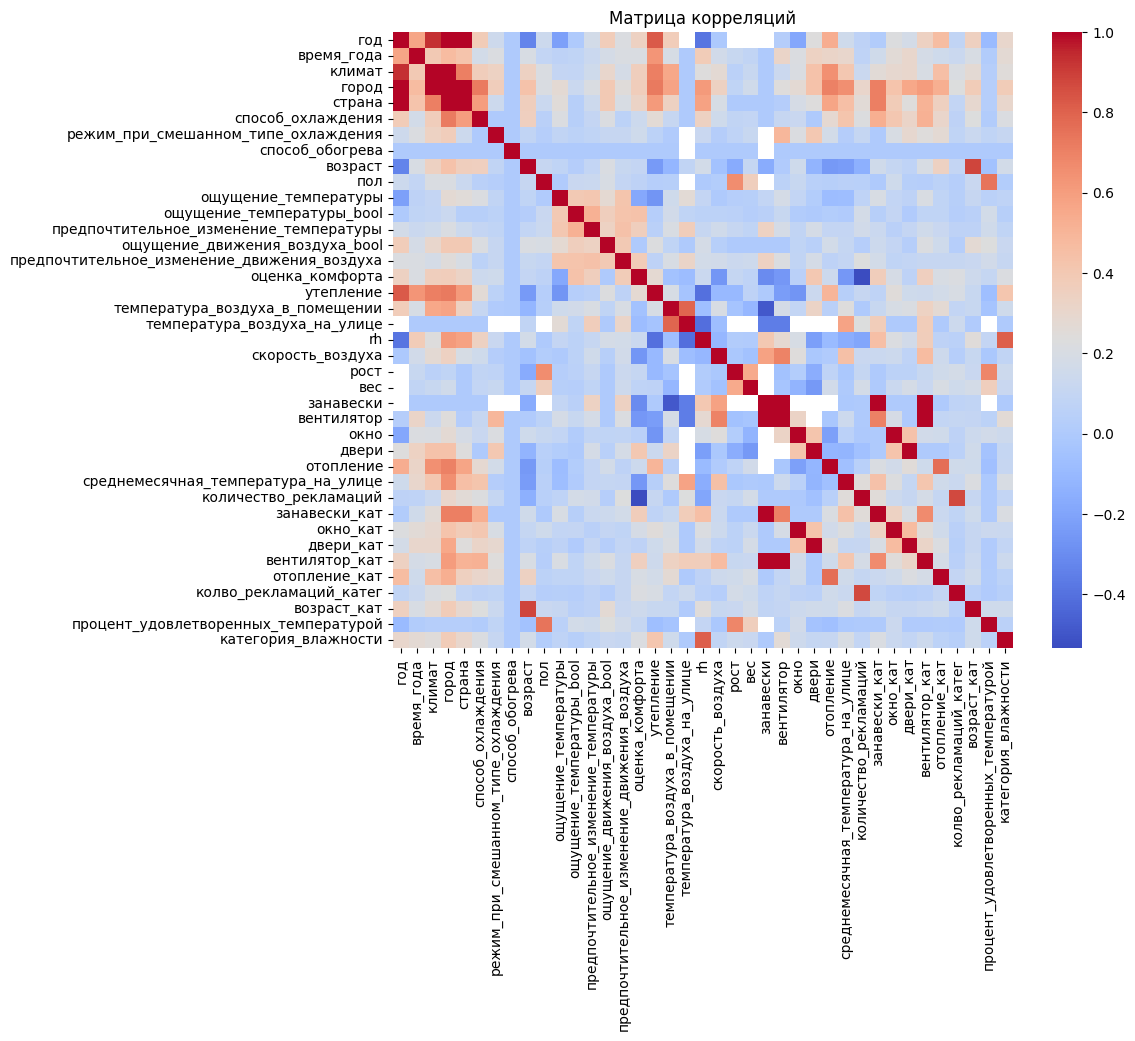

In [199]:
plt.figure(figsize=(10, 8))
corr_df = pd.DataFrame(index=df.columns, columns=df.columns)
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            corr_df.loc[col1, col2] = 1.0
        else:
            if df[col1].dtype in ('int64', 'float64') and df[col2].dtype in ('int64', 'float64'):
                dt1 = df[col1]
                dt2 = df[col2]
                if shapiro(dt1)[1] >= 0.05 and shapiro(dt2)[1] >= 0.05:
                    corr_df.loc[col1, col2] = df[[col1, col2]].corr().iloc[0, 1]
                else:
                    corr_df.loc[col1, col2] = df[[col1, col2]].corr(method='spearman').iloc[0, 1]
            elif df[col1].dtype in ['object', 'bool'] and df[col2].dtype in ['object', 'bool']:
                dt1 = df[col1]
                dt2 = df[col2]
                cramer = my_cramers(dt1, dt2)
                corr_df.loc[col1, col2] = round(cramer, 2)
            else:
                g = df.dropna(subset=[col1, col2])
                if df[col1].dtype in ['object', 'bool']:
                    corr_df.loc[col1, col2] = correlation_ratio(g[col1], g[col2])
                elif df[col2].dtype in ['object', 'bool']:
                    corr_df.loc[col1, col2] = correlation_ratio(g[col2], g[col1])

for col in corr_df.columns:
    corr_df[col] = corr_df[col].astype('float64')
sns.heatmap(corr_df, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()


#### Выводы по корреляциям

+ Факторы, которые коррелируют благодаря географическим особенностям: страна, город, климат, среднемесячная температура, относительная влажность, движение воздуха.
+ Также к этим фактором можно отнести утепление: оно зависит от того, в какой местности ты проживаешь. Наша матрица показывает, что чем хуже оценивают температуру люди, тем больше они "утепляются".
+ Наличие отопления зависит от местности, где проживают респонденты.
+ На температуру в помещении влияют следующие факторы: климат, город, страна, среднемесячная температура на улице, относительная влажность.
+ На оценку комфорта влияют следующие факторы: изменение движения воздуха и ощущение температуры, а также количество рекламаций. 
+ На факт, какой способ охлаждения выбирают клиенты влияют географические особенности. Еще мы можем увидеть зависимость от того, используют ли пользователи естественную вентиляцию или нет. Влажность в помещении таже важна для выбора способа охлаждения.

Все остальные зависимости не дают четкой картины, поэтому продолжим наше исследование и перейдем к гипотезам.

## Проверка гипотез

### Гипотезы, выдвинутые руководством

#### Влияет ли способ охлаждения на оценку комфорта? категориальная - количественная. 3 группы

In [200]:
df.groupby('способ_охлаждения')['оценка_комфорта'].count()

способ_охлаждения
Вентиляция            33
Кондиционирование    114
Смешанный            106
Name: оценка_комфорта, dtype: int64

In [201]:
conclusion(*testing_statistical_hypotheses(df, columns=['способ_охлаждения', 'оценка_комфорта']))

'Метод: Краскела–Уоллиса, stat: 6.543027422766037, p-value: 0.03794893983440494, ✅ Различия в оценке комфорта между группами статистически значимы.'

In [202]:
pvals, comparisons = pairwise_comparison_mannwhitn('способ_охлаждения', 'оценка_комфорта')
print("Попарные сравнения ")
for comp, p_adj in zip(comparisons, pvals):
    print(f"{comp}: p = {p_adj:.4f}")

Попарные сравнения 
Вентиляция vs Кондиционирование: p = 0.0310
Вентиляция vs Смешанный: p = 0.1245
Кондиционирование vs Смешанный: p = 0.0813


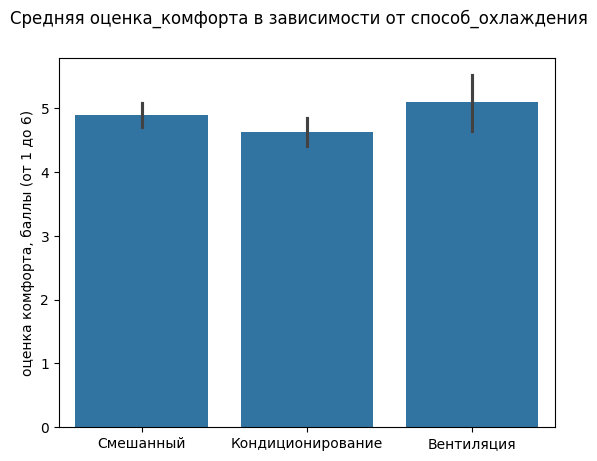

In [203]:
sns.barplot(df, x='способ_охлаждения', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка_комфорта в зависимости от способ_охлаждения')
plt.show()

In [204]:
# делаем вывод что тип охлаждения не влияет на оценку комфорта (хоть и это странно)

#### Влияет ли пол на оценку комфорта? категориальная - количественная. 2 группы

In [205]:
df.groupby('пол')['оценка_комфорта'].count()

пол
Женский     59
Мужской    122
Name: оценка_комфорта, dtype: int64

In [206]:
print(conclusion(*testing_statistical_hypotheses(df, columns=['пол', 'оценка_комфорта'], values=['Мужской', 'Женский'])))

Метод: Манн-Уитни, stat: 4037.0, p-value: 0.16951880319615675, 🚫 Различий в комфорте между группами не выявлено.


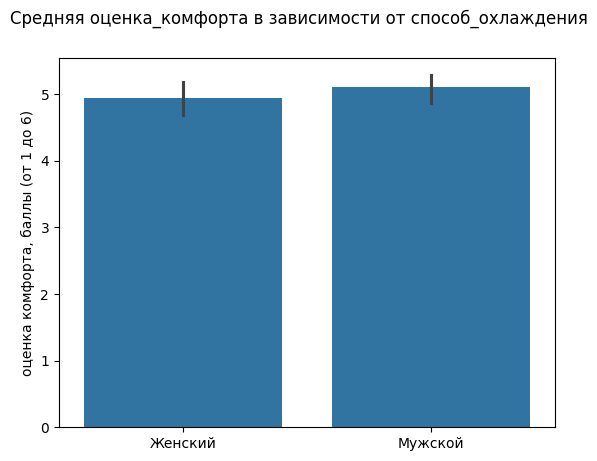

In [207]:
sns.barplot(df, x='пол', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка_комфорта в зависимости от способ_охлаждения')
plt.show()

In [208]:
# делаем вывод что пол не влияет на оценку комфорта

#### Влияет ли возрастная группа на оценку комфорта? категориальная - количественная. 3 группы (станет 2)

In [209]:
df.groupby('возраст_кат')['оценка_комфорта'].count()

возраст_кат
молодой возраст    181
пожилой возраст      1
средний возраст     71
Name: оценка_комфорта, dtype: int64

In [210]:
# людей входящий в пожилой_возраст всего 1, опустим эту категорию

In [211]:
conclusion(*testing_statistical_hypotheses(df, columns=['возраст_кат', 'оценка_комфорта'], values=['молодой возраст', 'средний возраст']))

'Метод: Краскела–Уоллиса, stat: 6.543027422766037, p-value: 0.03794893983440494, ✅ Различия в оценке комфорта между группами статистически значимы.'

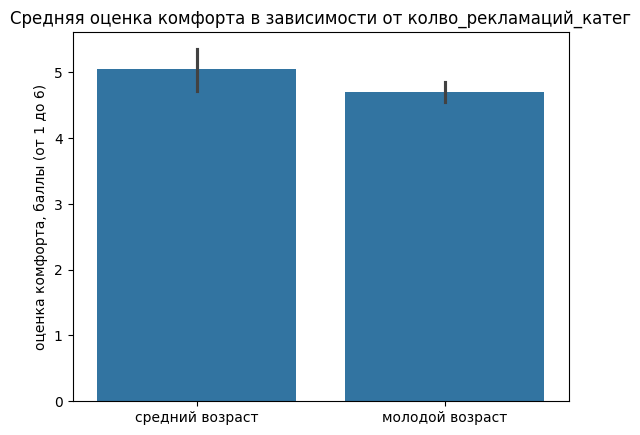

In [212]:
sns.barplot(data=df[df['возраст_кат'] != 'пожилой возраст'], x='возраст_кат', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.title('Средняя оценка комфорта в зависимости от колво_рекламаций_катег')
plt.show()

In [213]:
# делаем вывод что оценка комфорта различается для разных возрастных групп

#### Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта? категориальная - количественная. 3 группы

In [214]:
df.groupby('колво_рекламаций_катег')['оценка_комфорта'].count()

колво_рекламаций_катег
мало      245
много       5
средне      3
Name: оценка_комфорта, dtype: int64

In [215]:
conclusion(*testing_statistical_hypotheses(df=df, columns=['колво_рекламаций_катег', 'оценка_комфорта']))

'Метод: Краскела–Уоллиса, stat: 6.543027422766037, p-value: 0.03794893983440494, ✅ Различия в оценке комфорта между группами статистически значимы.'

In [216]:
pvals, comparisons = pairwise_comparison_mannwhitn('колво_рекламаций_катег', 'оценка_комфорта')
print("Попарные сравнения")
for comp, p_adj in zip(comparisons, pvals):
    print(f"{comp}: p = {p_adj:.4f}")

Попарные сравнения
мало vs много: p = 0.0219
мало vs средне: p = 0.0148
много vs средне: p = 0.4240


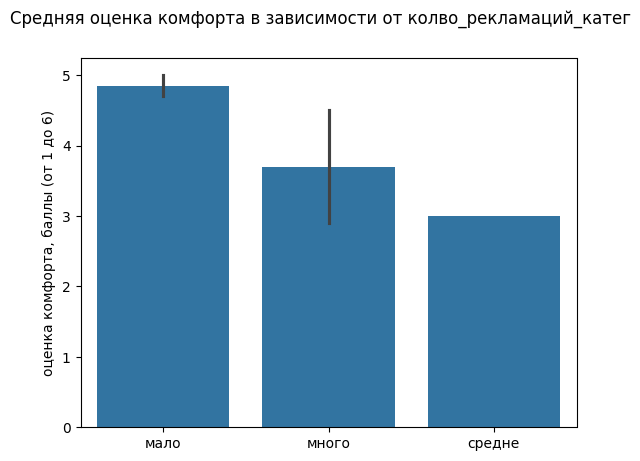

In [217]:
sns.barplot(df, x='колво_рекламаций_катег', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от колво_рекламаций_катег')
plt.show()

In [218]:
# делаем вывод что кол-во рекламаций влияет на оценку комфорта

####  Cредняя оценка комфорта отличается в зависимости от страны?

Для начала мы знаем, что у страны Австралии полностью отсутствуют данные оценка_комфорта, и у страны также Индия некоторые пропуски

оценка_комфорта

США Кол-во не пустых значений: 72, Австралия Кол-во не пустых значений: 0, Индия Кол-во не пустых значений: 212,

Так что будем смотреть оценку комфорта только у Индии и США

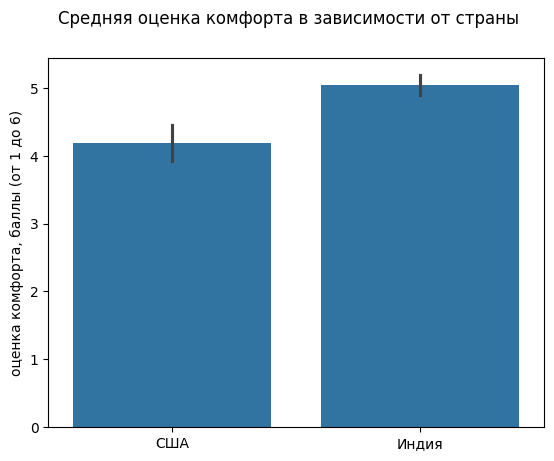

In [219]:
df_filt = df[df['страна'] != 'Австралия'][['страна', 'оценка_комфорта']].dropna()
# Рисуем график по стране и средней оценки 
sns.barplot(df_filt, x='страна', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от страны')
plt.show()

ВЫВОД Средняя оценка отличается в зависимости от страны

### Гипотезы, выдвинутые нашей командой

#### Взаимосвязаны ли относительная влажность в помещении и оценка комфорта?

In [220]:
# Анализ Индии
analize(df, 'Индия')
# У Австралии и США мало информации, поэтому не будем смотреть

Страна: Индия
высокая_влажность - Shapiro p = 0.0
комфортная_влажность - Shapiro p = 0.0
низкая_влажность - Shapiro p = 0.0021
Краскела Уолеса p = 0.22


Давайте нарисуем график:

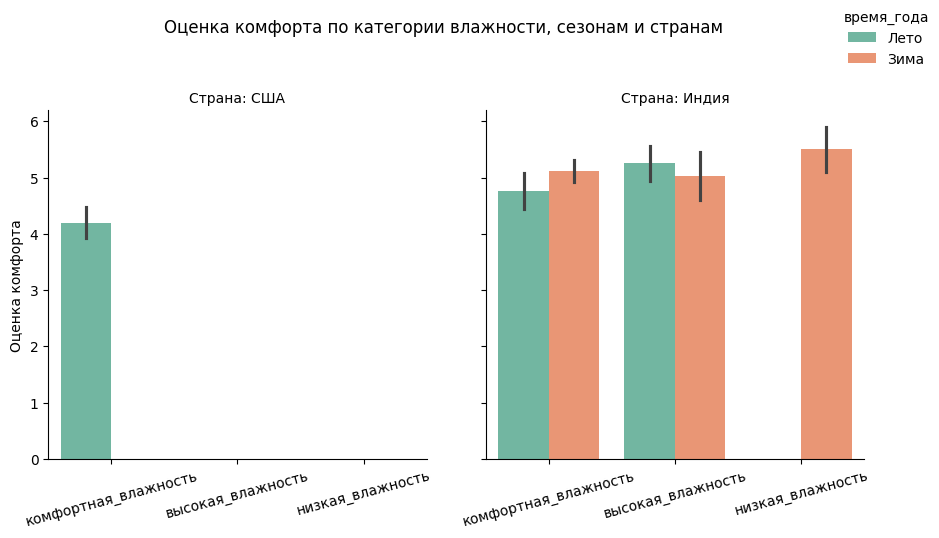

In [221]:
# Фильтруем датафрейм, убираем значения с временами года Весна и Лето, также убираем страну Австралия, так как по ним нет информации
df_filt = df[(df['время_года'] != 'Весна') & (df['время_года'] != 'Осень') & (df['страна'] != 'Австралия')]

# Строим boxplot с фасетами по странам
g = sns.catplot(
    data=df_filt,
    x='категория_влажности',
    y='оценка_комфорта',
    hue='время_года',
    col='страна',
    kind='bar',
    palette='Set2',
    height=5,
    aspect=0.8
)

g.set_axis_labels('', 'Оценка комфорта')
g.set_titles("Страна: {col_name}")
g.fig.suptitle('Оценка комфорта по категории влажности, сезонам и странам', y=1.05)
g.legend.set_bbox_to_anchor((1.05, 1))

# Повернуть подписи на оси X
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=15)
    
plt.tight_layout()
plt.show() 

ВЫВОД Так как pvalue > 0.05, значит нет значимой связи, люди в среднем чувствуют себя одинаково при разных уровнях влажности.

## Регрессионное моделирование

## Общий вывод